# **Darknet detection**


---


  
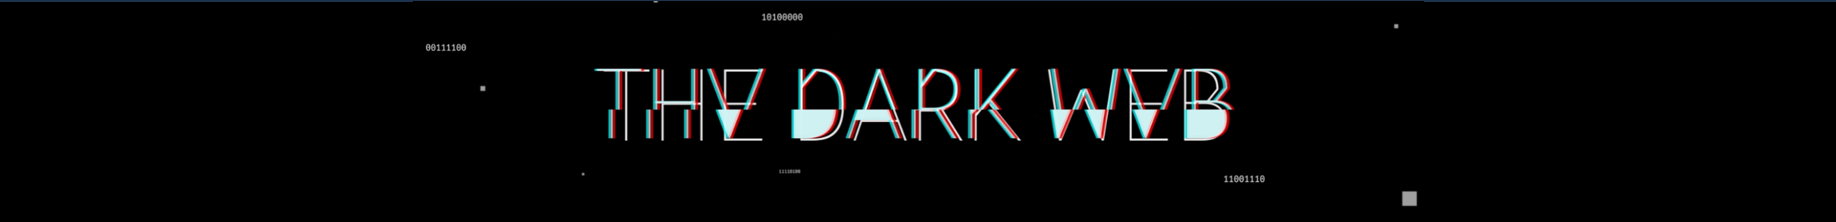







## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

# Introduction
This [dataset](https://www.unb.ca/cic/datasets/darknet2020.html) is a combination of two datasets of [Tor-nonTor](https://www.unb.ca/cic/datasets/tor.html) dataset and [VPN-nonVPN dataset](https://www.unb.ca/cic/datasets/vpn.html). With this dataset we aim to implement two Scenarios, first for detecting benign and Darknet traffic and second for classifing the type of the traffic.

In CICDarknet2020 dataset, a two-layered approach is used to generate benign and darknet traffic at the first layer. The darknet traffic constitutes Audio-Stream, Browsing, Chat, Email, P2P, Transfer, Video-Stream and VOIP which is generated at the second layer.

Our dataset has `141530` instances containig `83` input features with `2` different target labels.

## Importing dataset

In [ ]:
dataset = pd.read_csv("Darknet.csv")
dataset.shape

(141530, 85)

## Features names

In [ ]:
# Get the row using iloc and then retrieve the column names
column_names = dataset.columns
targets = ['Label', 'Label.1']
feature_names = [col for col in column_names if col not in targets]

print("Feature names:")
print(feature_names)
counts = len(feature_names)
print(f"\nThey are: {counts} features")

Feature names:
['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'A

## Print all unique labels

In [ ]:
Scenario1_labels = dataset.iloc[:,-2].unique()
Scenario2_labels = dataset.iloc[:,-1].unique()

print(f"Scenario1 labels:\n{Scenario1_labels}\n")
print(f"Scenario2 labels:\n{Scenario2_labels}")

Scenario1 labels:
['Non-Tor' 'NonVPN' 'Tor' 'VPN']

Scenario2 labels:
['AUDIO-STREAMING' 'Browsing' 'Chat' 'Email' 'File-Transfer'
 'File-transfer' 'P2P' 'Video-Streaming' 'Audio-Streaming'
 'Video-streaming' 'VOIP']


## Print count of each unique label
---
Some labels have been repeated with both lower and upper case that we will  handle it in 'converting labels' section.

In [ ]:
Scenario1_label_counts = dataset.iloc[:, -2].value_counts()
Scenario2_label_counts = dataset.iloc[:, -1].value_counts()

print(f"Seanrio1 label counts:\n{Scenario1_label_counts}\n")
print(f"Seanrio2 label counts:\n{Scenario2_label_counts}")

Seanrio1 label counts:
Label
Non-Tor    93356
NonVPN     23863
VPN        22919
Tor         1392
Name: count, dtype: int64

Seanrio2 label counts:
Label.1
P2P                48520
Browsing           32808
Audio-Streaming    16580
Chat               11478
File-Transfer      11098
Video-Streaming     9486
Email               6145
VOIP                3566
AUDIO-STREAMING     1484
Video-streaming      281
File-transfer         84
Name: count, dtype: int64


## Droping Flow ID column which is not effective for training

In [ ]:
def drop_column(data, feature_names):
  columns = ['Flow ID']
  # Drop the specified columns
  data = dataset.drop(columns=columns, axis=1)
  feature_names = [col for col in feature_names if col not in columns]
  return data, feature_names

In [ ]:
# Droping Flow ID column in the dataset
dropped_data, dropped_feature_names = drop_column(dataset, feature_names)

# Defining preprocessing functions

## Checking if there are any missing values in the dataset

In [ ]:
def check_missing(data):
    missing_flag = False
    for column in data.columns:
        missing_count = data[column].isnull().sum()
        if missing_count > 0:
            print(f"Feature '{column}' has {missing_count} missing values.")
            missing_flag = True

    if not missing_flag:
        print("No missing data in the whole dataset.")

In [ ]:
# checking missing data in the dataset
check_missing(dropped_data)

Feature 'Flow Bytes/s' has 47 missing values.


## Dropping the missing data using missing_delete function

In [ ]:
def missing_delete(data):
    data = data.dropna()
    return data

In [ ]:
# deleting the missing vaues in dataset
no_missing_data = missing_delete(dropped_data)

In [ ]:
# checking if missing data is dropped
check_missing(no_missing_data)

No missing data in the whole dataset.


## Checking if we have categorical features

In [ ]:
categorical_columns = no_missing_data.select_dtypes(exclude=['float64', 'int64']).columns
if len(categorical_columns) > 0:
    print("The dataset has categorical columns.")
    print("Categorical columns:", list(categorical_columns))
else:
    print("The dataset does not have any categorical columns.")

The dataset has categorical columns.
Categorical columns: ['Src IP', 'Dst IP', 'Timestamp', 'Label', 'Label.1']


## Converting categorical features

In [ ]:
def cat_conv(data):
    data.loc[:,'Src IP'] = data.loc[:,'Src IP'].apply(hash).astype('float64')
    data.loc[:,'Dst IP'] = data.loc[:,'Dst IP'].apply(hash).astype('float64')
    data.loc[:,'Timestamp'] = data.loc[:,'Timestamp'].apply(hash).astype('float64')

    return data

In [ ]:
# Converting categorical features to numeric ones in the dataset
clean_data = cat_conv(no_missing_data)

## Creating X and y
---
Dividing the dataset to features (X) and labels (y)

In [ ]:
from sklearn.model_selection import train_test_split
def X_y_creation(dataset, label_index):

    X = dataset.iloc[:, :-2]
    y = dataset.iloc[:, label_index]
    return X, y

In [ ]:
# X, y for Scenario1
X, y_binary = X_y_creation(clean_data, -2)

In [ ]:
# X, y for Scenario2
X, y_multi = X_y_creation(clean_data, -1)

## Dropping infinite values in the entire DataFrame

In [ ]:
def infinite_value_drop(X, y):
    # Replacing infinite features with NaN
    X_inf_dropped = X.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    # Droping NaN features
    y_inf_dropped = y[X.index.isin(X_inf_dropped.index)]
    return X_inf_dropped, y_inf_dropped

In [ ]:
# Dropping infinite values for Scenario1
X_inf_dropped, y_binary_inf_dropped = infinite_value_drop(X, y_binary)

In [ ]:
# Dropping infinite values for Scenario2
X_inf_dropped, y_multi_inf_dropped = infinite_value_drop(X, y_multi)

## Converting labels for Scenario1
---
Converting VPN and Tor labels to Darknet, NonVPN and Non-Tor to Benign and then Darknet to 1 and Benign to 0.

In [ ]:
# Create a new column 'y' based on the mapping
def converting_binary(y):
    y = y.map({'VPN': 'Darknet', 'Tor': 'Darknet', 'NonVPN': 'Benign', 'Non-Tor': 'Benign'})
    y = y.map({'Darknet':1, 'Benign': 0})
    return y

In [ ]:
# Converting y_binary to numeric values
y_binary_converted = converting_binary(y_binary_inf_dropped)
print(y_binary_converted)
print(f'\nNow the labels are: {y_binary_converted.unique()}')

0         0
1         0
2         0
3         0
4         0
         ..
141525    1
141526    1
141527    1
141528    1
141529    1
Name: Label, Length: 141481, dtype: int64

Now the labels are: [0 1]


## Converting labels for Scenario2
---

Converting all labels to  lowercase, then convert them from nominal to numeric ones using Label Encoding in Scenario2.

In [ ]:
from sklearn.preprocessing import LabelEncoder
def converting_multi(y):
    # Convert all labels to lowercase
    y_lower = [label.lower() for label in y]

    # Use LabelEncoder on lowercase labels
    label_encoder = LabelEncoder()
    y_numeric_multi = label_encoder.fit_transform(y_lower)
    y_numeric_multi = pd.Series(y_numeric_multi)

    return y_numeric_multi

In [ ]:
# Converting y_multi to numeric values
y_multi_converted = converting_multi(y_multi_inf_dropped)
print(y_multi_converted)
print(f'\nNow the labels are: {y_multi_converted.unique()}')

0         0
1         0
2         0
3         0
4         0
         ..
141476    7
141477    7
141478    7
141479    7
141480    7
Length: 141481, dtype: int64

Now the labels are: [0 1 2 3 4 5 6 7]


## Standardizing features
---
Standardization transforms the features to have a mean of 0 and a standard deviation of 1. This process is also known as Z-score normalization. For not having information leakage, we compute the mean and standard deviation(fit) only from the training data and then apply the results to both(transformation).

In [ ]:
def standardization(X_train, X_test):
    from sklearn.preprocessing import StandardScaler

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

<!-- ### Finding Correlations -->

## Feature selection
---
This tree-based feature selection method uses an ensemble of decision trees (ExtraTreesClassifier) to estimate feature importance and selects a subset of features based on their importance scores.

In [ ]:
def feature_selection(X, data, X_train, y_train, X_test):
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.datasets import load_iris
    from sklearn.feature_selection import SelectFromModel

    clf = ExtraTreesClassifier(n_estimators=50)
    clf.fit(X_train, y_train)
    model = SelectFromModel(clf, prefit=True)
    X_train = model.transform(X_train)
    X_test = model.transform(X_test)
    selected_feature_indices = model.get_support(indices=True)
    selected_features = [dropped_feature_names[i] for i in selected_feature_indices]
    return X_train, X_test, selected_features

## Checking if data is imbalanced

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def check_imbalancing(y):
    class_counts = y.value_counts()

    # Set a color palette with different colors for each class
    colors = sns.color_palette("husl", len(class_counts))

    plt.figure(figsize=(8, 6))
    class_counts.plot(kind='bar', color=colors)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    # Rotate x-axis labels to be horizontal
    plt.xticks(rotation=0)
    plt.show()

    imbalance_ratio = class_counts.min() / class_counts.max()

    print("Class Counts:")
    print(class_counts)
    print("Imbalance Ratio: {:.2f}".format(imbalance_ratio))

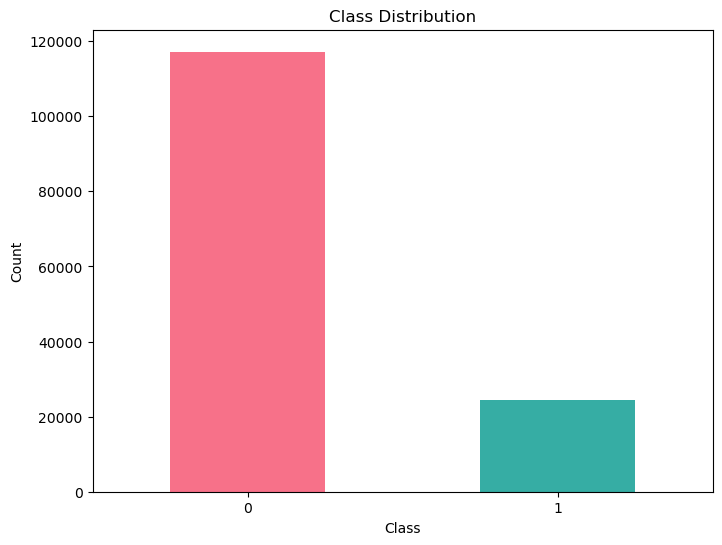

Class Counts:
Label
0    117170
1     24311
Name: count, dtype: int64
Imbalance Ratio: 0.21


In [ ]:
# Checking if data is imbalanced in Scenario1
check_imbalancing(y_binary_converted)

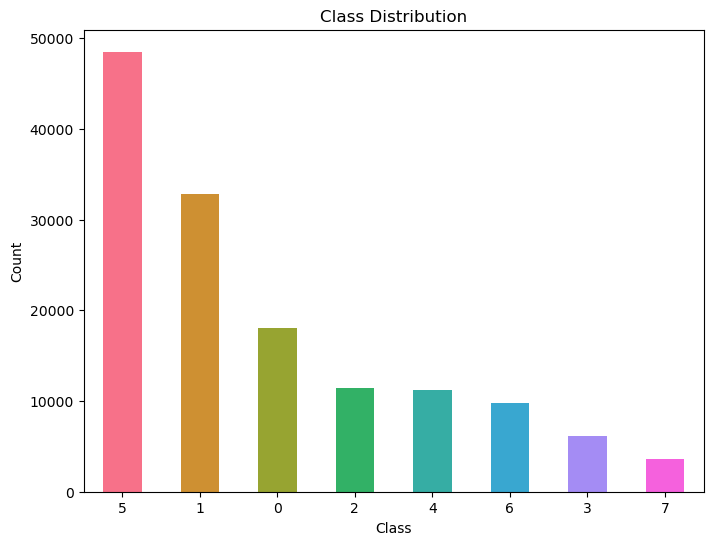

Class Counts:
5    48520
1    32808
0    18050
2    11473
4    11173
6     9748
3     6143
7     3566
Name: count, dtype: int64
Imbalance Ratio: 0.07


In [ ]:
# Checking if data is imbalanced in Scenario2
check_imbalancing(y_multi_converted)

## Balancing with SMOTE

In [ ]:
def smote(X_train, y_train):
    from collections import Counter
    from sklearn.datasets import make_classification
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    return X_train, y_train

## Hyperparameter Tuning with Grid search

In [ ]:
def HyperP_tuning(model, HyperParameters, X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    grid_search = GridSearchCV(estimator=model, param_grid=HyperParameters, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    model = grid_search.best_estimator_
    return model, best_params

# main function
---

It will do all trainig, and prediction steps for both scenarios. This approach makes us able to be more efficient and do the DRY principle which stands for "Don't Repeat Yourself!"

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def main(X_train, X_test, y_train, y_test, model, feature_names,
         standardization, feature_selection, balancing, HyperParameters, HyperP_tuning):

    X_train, X_test = standardization(X_train, X_test)
    X_train, X_test, selected_features = feature_selection(X, dataset, X_train, y_train, X_test)
    X_train, y_train = balancing(X_train, y_train)
    model, best_params = HyperP_tuning(model, HyperParameters, X_train, y_train) # Trainig
    y_pred = model.predict(X_test) # Predicting
    f1_score_weighted= f1_score(y_test, y_pred, average='weighted')
    precision_weighted= precision_score(y_test, y_pred, average='weighted')
    recall_weighted= recall_score(y_test, y_pred, average='weighted')
    return model, selected_features, best_params, f1_score_weighted, precision_weighted, recall_weighted, y_pred

# Stratified cross-validation
---
Using Stratified cross-validation for splitting dataset to train set and test set with 5 splits, instead of normal splitting.

## main_with_crossval
---
We call main function inide of main_with_crossvall function for training and testing model on each mini train set and test set created from Stratified cross-validation.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def main_with_crossval(model, label_index, converting_func, HyperParameters, dataset=dataset, drop_column=drop_column,
    missing_delete = missing_delete,
    cat_conv = cat_conv,
    main_func = main,
    X_y_creation = X_y_creation,
    infinite_value_drop = infinite_value_drop):

    dropped_data, dropped_feature_names = drop_column(dataset, feature_names)
    no_missing_data = missing_delete(dropped_data)
    clean_data = cat_conv(no_missing_data)
    X, y = X_y_creation(clean_data, label_index)
    X, y = infinite_value_drop(X, y)
    y = converting_func(y)
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    f1_scores = []
    precisions = []
    recalls = []
    X = X.values
    y = y.values
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model, selected_features, best_params, f1_score_weighted, precision_weighted, recall_weighted, y_pred = main(X_train,X_test,y_train,y_test,model,
                                                                                                                feature_names=dropped_feature_names,
                                                                                                                standardization=standardization,
                                                                                                                feature_selection=feature_selection,
                                                                                                                balancing=smote,
                                                                                                                HyperParameters=HyperParameters,
                                                                                                                HyperP_tuning=HyperP_tuning)
        predictions = y_pred
        f1_scores.append(f1_score_weighted)
        precisions.append(precision_weighted)
        recalls.append(recall_weighted)

    f1_avg = np.mean(f1_scores)
    precision_avg = np.mean(precisions)
    recall_avg = np.mean(recalls)

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    return f1_avg, precision_avg, recall_avg, model, selected_features, best_params

## RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion = 'entropy', random_state = 0)

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 0)

## K-Nearest Neighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

## Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(random_state = 0)

## XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

# Scenario 1: Benign/Darknet Detection


---
`Binary Classfication`

Using `benign` and `darknet` labels as 0 and 1.



## Random Forest_Scenario1

In [ ]:
rf_parameters =  {
    'n_estimators': [10, 100, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [5, 10]
}

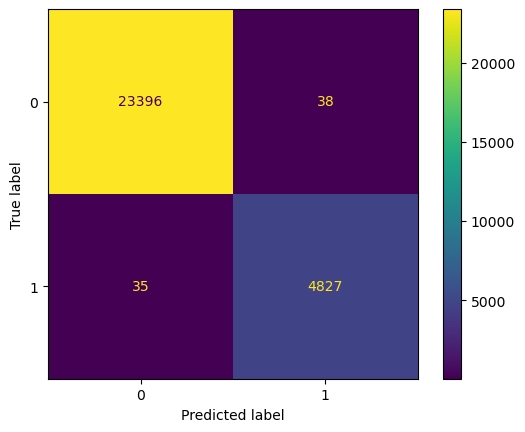

Binary F1 Average (rf): 0.9976674238349089

Binary Precision Average (rf): 0.9976675041235344

Binary Recall Average (rf): 0.9976675320781808

Selected Features: ['Src IP', 'Dst IP', 'Dst Port', 'Protocol', 'Flow Duration', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Max', 'Packet Length Std', 'FIN Flag Count', 'Bwd Segment Size Avg', 'Subflow Fwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Binary best Parameters for rf: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 10}


In [ ]:
binary_f1_avg_rf, binary_precision_avg_rf,binary_recall_avg_rf,binary_model_rf, selected_features,binary_best_params_rf = main_with_crossval(model = rf,
                                                                                                                     converting_func = converting_binary,
                                                                                                                     label_index = -2,
                                                                                                                     HyperParameters = rf_parameters)


print(f"Binary F1 Average (rf): {binary_f1_avg_rf}\n")
print(f"Binary Precision Average (rf): {binary_precision_avg_rf}\n")
print(f"Binary Recall Average (rf): {binary_recall_avg_rf}\n")
print(f"Selected Features: {selected_features}\n")
print(f"Binary best Parameters for rf: {binary_best_params_rf}")

## Decision Tree_Scenario1

In [ ]:
dt_parameters =  {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["entropy", "gini"]
}

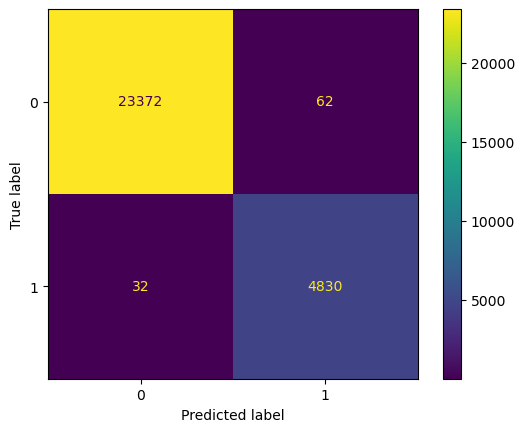

Binary F1 Average (dt): 0.9969986841547366

Binary Precision Average (dt): 0.9970036133116101

Binary Recall Average (dt): 0.9969960668217667

Selected Features: ['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Length of Bwd Packet', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Max', 'Flow IAT Min', 'Fwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Mean', 'Packet Length Std', 'FIN Flag Count', 'ACK Flag Count', 'Bwd Segment Size Avg', 'Subflow Fwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Binary best Parameters for dt: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5}


In [ ]:
binary_f1_avg_dt, binary_precision_avg_dt,binary_recall_avg_dt,binary_model_dt, selected_features,binary_best_params_dt = main_with_crossval(model = dt,
                                                                                                                     converting_func = converting_binary,
                                                                                                                     label_index = -2,
                                                                                                                     HyperParameters = dt_parameters)


print(f"Binary F1 Average (dt): {binary_f1_avg_dt}\n")
print(f"Binary Precision Average (dt): {binary_precision_avg_dt}\n")
print(f"Binary Recall Average (dt): {binary_recall_avg_dt}\n")
print(f"Selected Features: {selected_features}\n")
print(f"Binary best Parameters for dt: {binary_best_params_dt}")

## KNN_Scenario1

In [ ]:
knn_parameters =  {
    'p': [1, 2],
    'n_neighbors' : [3, 5, 7, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}

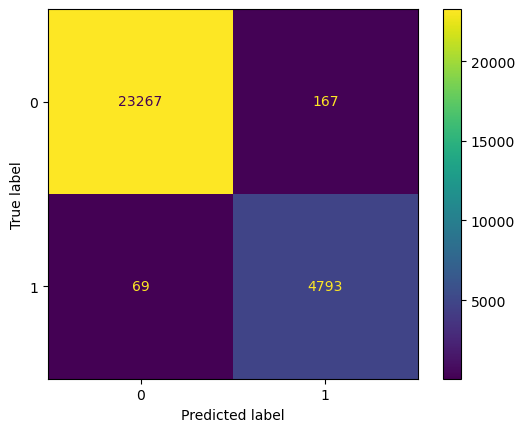

Binary F1 Average (knn): 0.9917983075505316

Binary Precision Average (knn): 0.9918725572025309

Binary Recall Average (knn): 0.9917656805305659

Selected Features: ['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Total Length of Bwd Packet', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Max', 'Packet Length Std', 'FIN Flag Count', 'Average Packet Size', 'Bwd Segment Size Avg', 'Subflow Fwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Binary best Parameters for knn: {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}


In [ ]:
binary_f1_avg_knn, binary_precision_avg_knn, binary_recall_avg_knn, binary_model_knn, selected_features,binary_best_params_knn = main_with_crossval(model = knn,
                                                                                                                     converting_func = converting_binary,
                                                                                                                     label_index = -2,
                                                                                                                     HyperParameters = knn_parameters)


print(f"Binary F1 Average (knn): {binary_f1_avg_knn}\n")
print(f"Binary Precision Average (knn): {binary_precision_avg_knn}\n")
print(f"Binary Recall Average (knn): {binary_recall_avg_knn}\n")
print(f"Selected Features: {selected_features}\n")
print(f"Binary best Parameters for knn: {binary_best_params_knn}")

## Logistic Regression_Scenario1

In [ ]:
log_parameters =  {
    'penalty': ['none', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg','lbfgs', 'liblinear']
}

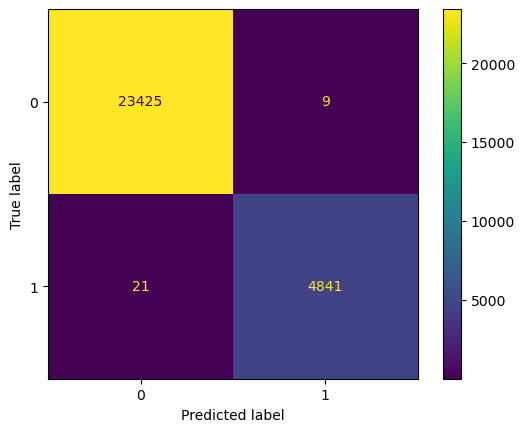

Binary F1 Average (log): 0.9989324758533658

Binary Precision Average (log): 0.9989325420694801

Binary Recall Average (log): 0.9989327190805944

Selected Features: ['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Max', 'Flow IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'FIN Flag Count', 'Bwd Segment Size Avg', 'Subflow Fwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Binary best Parameters for log: {'booster': 'gbtree', 'enable_categorical': True, 'gamma': 0.4, 'learning_rate': 0.2, 'objective': 'binary:logistic', 'subsample': 0.9, 'tree_method': 'hist', 'verbosity': 0}


In [ ]:
binary_f1_avg_log, binary_precision_avg_log, binary_recall_avg_log, binary_model_log, selected_features,binary_best_params_log = main_with_crossval(model = log,
                                                                                                                     converting_func = converting_binary,
                                                                                                                     label_index = -2,
                                                                                                                     HyperParameters = log_parameters)


print(f"Binary F1 Average (log): {binary_f1_avg_log}\n")
print(f"Binary Precision Average (log): {binary_precision_avg_log}\n")
print(f"Binary Recall Average (log): {binary_recall_avg_log}\n")
print(f"Selected Features: {selected_features}\n")
print(f"Binary best Parameters for log: {binary_best_params_log}")

## XGBoost_Scenario1

In [ ]:
xgb_parameters ={
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9],
    'tree_method': ['auto', 'exact', 'approx', 'hist'],
    'enable_categorical':[True, False],
    'booster':['gbtree', 'gblinear', 'dart'],
    'objective':['reg:squarederror', 'multi:softmax', 'binary:logistic'],
    'verbosity':[0,1,2],
    'learning_rate':[0.01, 0.1, 0.2],
    'subsample':[0.8, 1.0, 0.9]
}

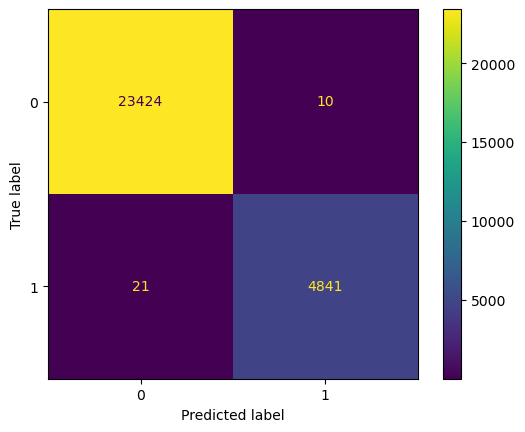

Binary F1 Average (xgb): 0.9988972001132759

Binary Precision Average (xgb): 0.9988974137858742

Binary Recall Average (xgb): 0.9988973786461827

Selected Features: ['Src IP', 'Dst IP', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Length of Bwd Packet', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Max', 'Flow IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Mean', 'Packet Length Std', 'Average Packet Size', 'Bwd Segment Size Avg', 'Subflow Fwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Binary best Parameters for xgb: {'booster': 'gbtree', 'enable_categorical': True, 'gamma': 0.4, 'learning_rate': 0.2, 'objective': 'binary:logistic', 'subsample': 0.9, 'tree_method': 'hist', 'verbosity': 0}


In [ ]:
binary_f1_avg_xgb, binary_precision_avg_xgb, binary_recall_avg_xgb, binary_model_xgb, selected_features,binary_best_params_xgb = main_with_crossval(model = xgb,
                                                                                                                     converting_func = converting_binary,
                                                                                                                     label_index = -2,
                                                                                                                     HyperParameters = xgb_parameters)

print(f"Binary F1 Average (xgb): {binary_f1_avg_xgb}\n")
print(f"Binary Precision Average (xgb): {binary_precision_avg_xgb}\n")
print(f"Binary Recall Average (xgb): {binary_recall_avg_xgb}\n")
print(f"Selected Features: {selected_features}\n")
print(f"Binary best Parameters for xgb: {binary_best_params_xgb}")

## Comparing models_Scenario1

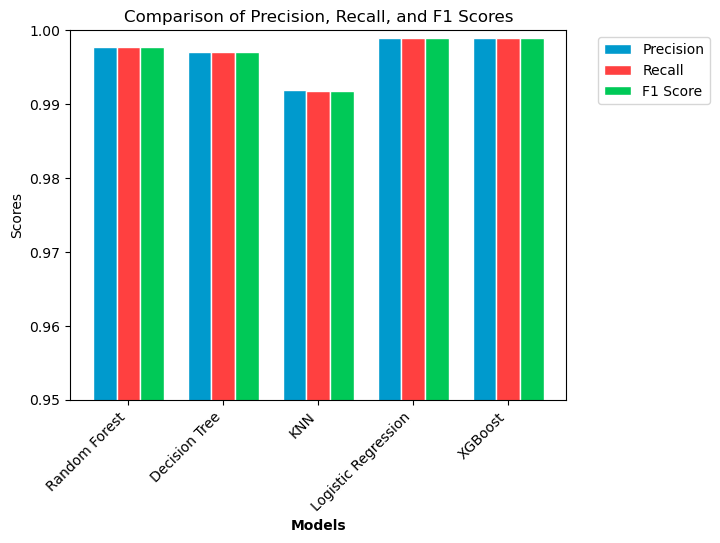

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your data
f1_scores = [binary_f1_avg_rf, binary_f1_avg_dt, binary_f1_avg_knn, binary_f1_avg_log, binary_f1_avg_xgb]
precision_scores = [binary_precision_avg_rf, binary_precision_avg_dt, binary_precision_avg_knn, binary_precision_avg_log, binary_precision_avg_xgb]
recall_scores = [binary_recall_avg_rf, binary_recall_avg_dt, binary_recall_avg_knn, binary_recall_avg_log, binary_recall_avg_xgb]
labels = ['Random Forest', 'Decision Tree', 'KNN', 'Logistic Regression', 'XGBoost']

# Bar width
bar_width = 0.25

# Set up positions for the bars
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the grouped bar plot
plt.bar(r1, precision_scores, color='#009ACD', width=bar_width, edgecolor='white', label='Precision')
plt.bar(r2, recall_scores, color='#FF4040', width=bar_width, edgecolor='white', label='Recall')
plt.bar(r3, f1_scores, color='#00C957', width=bar_width, edgecolor='white', label='F1 Score')

# Adding labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(labels))], labels)
plt.ylabel('Scores')
plt.title('Comparison of Precision, Recall, and F1 Scores')
plt.xticks(rotation=45, ha='right')

# Increase the number of y-axis ticks
plt.yticks(np.arange(0.8, 1.01, 0.01))

# Set y-axis limits
plt.ylim(0.95, 1)

# Move the legend to the upper right corner
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

# Scenario 2: Type of traffic Detection


---

**Multiclass classification problem**

Labels that show the types of traffic: `browsing`, `chat`, `email`, `File-transfer`, `P2P`, `video-streaming`, `audio-streaming`, `voip` which we have converted to numbers from 0 to 7.

## RandomForest_Scenario2

In [ ]:
rf_parameters =  {
    'n_estimators': [10, 100, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [5, 10]
}

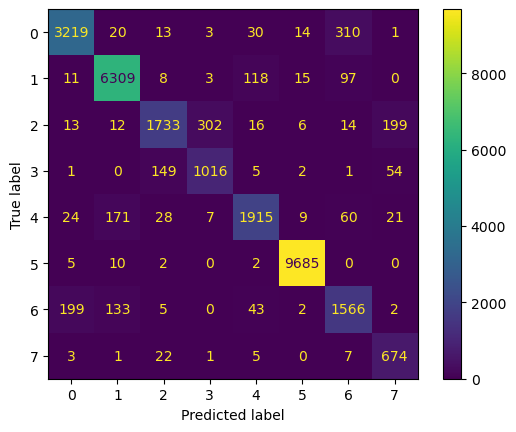

Multi F1 Average (rf): 0.9239499131701348

Multi Precision Average (rf): 0.9263347918383289

Multi Recall Average (rf): 0.9237565389570215

Selected Features: ['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Bwd Packet Length Max', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Mean', 'FIN Flag Count', 'Subflow Fwd Packets', 'FWD Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Multi best Parameters for rf: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}


In [ ]:
multi_f1_avg_rf, multi_precision_avg_rf,multi_recall_avg_rf,multi_model_rf, selected_features,multi_best_params_rf = main_with_crossval(model = rf,
                                                                                                                     converting_func = converting_multi,
                                                                                                                     label_index = -1,
                                                                                                                     HyperParameters = rf_parameters)


print(f"Multi F1 Average (rf): {multi_f1_avg_rf}\n")
print(f"Multi Precision Average (rf): {multi_precision_avg_rf}\n")
print(f"Multi Recall Average (rf): {multi_recall_avg_rf}\n")
print(f"Selected Features: {selected_features}\n")
print(f"Multi best Parameters for rf: {multi_best_params_rf}")

## Decision Tree_Scenario2

In [ ]:
dt_parameters =  {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["entropy", "gini"]
}

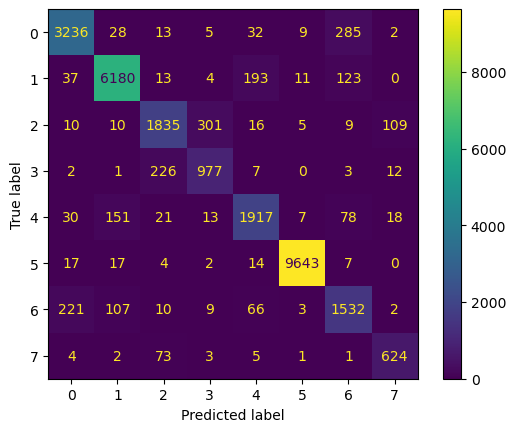

Multi F1 Average (dt): 0.9162492489461936

Multi Precision Average (dt): 0.9172225805462457

Multi Recall Average (dt): 0.9157271884619711

Selected Features: ['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Bwd Packet Length Min', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Std', 'FIN Flag Count', 'Bwd Segment Size Avg', 'Subflow Fwd Packets', 'FWD Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Multi best Parameters for dt: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5}


In [ ]:
multi_f1_avg_dt, multi_precision_avg_dt,multi_recall_avg_dt,multi_model_dt, selected_features, multi_best_params_dt = main_with_crossval(model = dt,
                                                                                                                     converting_func = converting_multi,
                                                                                                                     label_index = -1,
                                                                                                                     HyperParameters = dt_parameters)


print(f"Multi F1 Average (dt): {multi_f1_avg_dt}\n")
print(f"Multi Precision Average (dt): {multi_precision_avg_dt}\n")
print(f"Multi Recall Average (dt): {multi_recall_avg_dt}\n")
print(f"Selected Features: {selected_features}\n")
print(f"Multi best Parameters for dt: {multi_best_params_dt}")

## XGBoost_Scenario2

In [ ]:
xgb_parameters ={
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9],
    'tree_method': ['auto', 'exact', 'approx', 'hist'],
    'enable_categorical':[True, False],
    'booster':['gbtree', 'gblinear', 'dart'],
    'objective':['reg:squarederror', 'multi:softmax', 'binary:logistic'],
    'verbosity':[0,1,2],
    'learning_rate':[0.01, 0.1, 0.2],
    'subsample':[0.8, 1.0, 0.9]
}

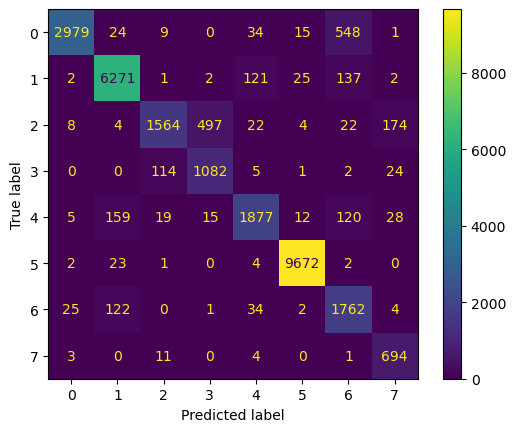

Multi F1 Average (xgb): 0.9163545533455348

Multi Precision Average (xgb): 0.9264553943704001

Multi Recall Average (xgb): 0.915225365483647

Selected Features: ['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'FIN Flag Count', 'Average Packet Size', 'Subflow Fwd Packets', 'FWD Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Multi best Parameters for xgb: {'booster': 'gbtree', 'enable_categorical': True, 'gamma': 0.2, 'learning_rate': 0.1, 'objective': 'reg:squarederror', 'subsample': 0.8, 'tree_method': 'hist', 'verbosity': 0}


In [ ]:
multi_f1_avg_xgb, multi_precision_avg_xgb,multi_recall_avg_xgb, multi_model_xgb, selected_features, multi_best_params_xgb = main_with_crossval(model = xgb,
                                                                                                                     converting_func = converting_multi,
                                                                                                                     label_index = -1,
                                                                                                                     HyperParameters = xgb_parameters)


print(f"Multi F1 Average (xgb): {multi_f1_avg_xgb}\n")
print(f"Multi Precision Average (xgb): {multi_precision_avg_xgb}\n")
print(f"Multi Recall Average (xgb): {multi_recall_avg_xgb}\n")
print(f"Selected Features: {selected_features}\n")
print(f"Multi best Parameters for xgb: {multi_best_params_xgb}")

## VotingClassifier
---
Ensumbling Random Forest and XGBoost models

## VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier
# Create a VotingClassifier
vote = VotingClassifier(estimators=[('rf', multi_model_rf), ('xgb', multi_model_xgb)], voting='soft')
vote_parameters = {}

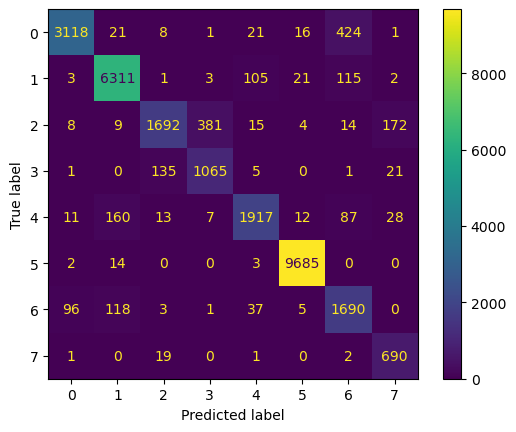

Multi F1 Average (vote): 0.9264969391207336

Multi Precision Average (vote): 0.9316829540514148

Multi Recall Average (vote): 0.925884050643439

Selected Features: ['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'FIN Flag Count', 'Subflow Fwd Packets', 'FWD Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Multi best Parameters for vote: {}


In [ ]:
multi_f1_avg_vote, multi_precision_avg_vote,multi_recall_avg_vote,multi_model_vote, selected_features, multi_best_params_vote = main_with_crossval(model = vote,
                                                                                                                     converting_func = converting_multi,
                                                                                                                     label_index = -1,
                                                                                                                     HyperParameters = vote_parameters)


print(f"Multi F1 Average (vote): {multi_f1_avg_vote}\n")
print(f"Multi Precision Average (vote): {multi_precision_avg_vote}\n")
print(f"Multi Recall Average (vote): {multi_recall_avg_vote}\n")
print(f"Selected Features: {selected_features}\n")
print(f"Multi best Parameters for vote: {multi_best_params_vote}")

## Comparing models_Scenario2

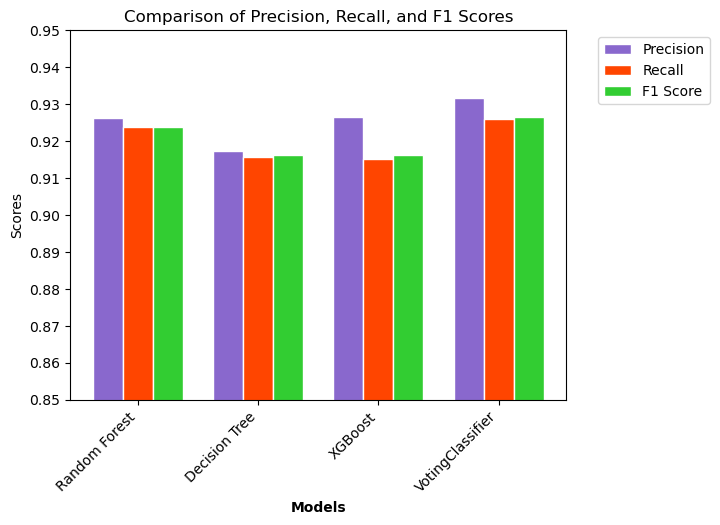

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your data
f1_scores = [multi_f1_avg_rf, multi_f1_avg_dt, multi_f1_avg_xgb, multi_f1_avg_vote]
precision_scores = [multi_precision_avg_rf, multi_precision_avg_dt, multi_precision_avg_xgb, multi_precision_avg_vote]
recall_scores = [multi_recall_avg_rf, multi_recall_avg_dt, multi_recall_avg_xgb, multi_recall_avg_vote]
labels = ['Random Forest', 'Decision Tree', 'XGBoost', 'VotingClassifier']

# Bar width
bar_width = 0.25

# Set up positions for the bars
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the grouped bar plot
plt.bar(r1, precision_scores, color='#8968CD', width=bar_width, edgecolor='white', label='Precision')
plt.bar(r2, recall_scores, color='#FF4500', width=bar_width, edgecolor='white', label='Recall')
plt.bar(r3, f1_scores, color='#32CD32', width=bar_width, edgecolor='white', label='F1 Score')

# Adding labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(labels))], labels)
plt.ylabel('Scores')
plt.title('Comparison of Precision, Recall, and F1 Scores')
plt.xticks(rotation=45, ha='right')

# Increase the number of y-axis ticks
plt.yticks(np.arange(0.8, 1.01, 0.01))

# Set y-axis limits
plt.ylim(0.85, 0.95)

# Move the legend to the upper right corner
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()


# Best features
---

for both Scenarios they are the same as we are using one dataset and the same feature selection method for both Scenarios.

In [ ]:
print(selected_features)
print(f"\nThere are {len(selected_features)} features selected.")

['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'FIN Flag Count', 'Subflow Fwd Packets', 'FWD Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min']

There are 26 features selected.
